In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np



import gc


import glob

import os

In [455]:
df = pd.read_csv('data/mafat_wifi_challenge_training_set_v1.csv')

In [456]:
df.head()

,Time,Room_Num,Device_ID,RSSI_Left,RSSI_Right,Num_People
0,0.0,3,92178,-42,-51,2.0
1,0.5,3,92178,-42,-51,2.0
2,1.0,3,92178,-42,-51,2.0
3,1.5,3,92178,-42,-51,2.0
4,2.0,3,92178,-42,-51,2.0


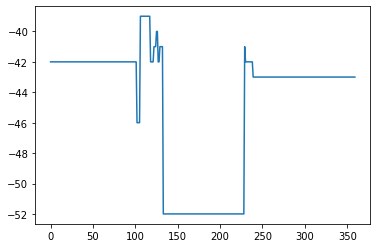

In [457]:
plt.plot(df.RSSI_Left.head(360))

In [458]:
df[df.Num_People==1].head()

,Time,Room_Num,Device_ID,RSSI_Left,RSSI_Right,Num_People
1731,865.5,3,92178,-39,-46,1.0
1732,866.0,3,92178,-39,-46,1.0
1733,866.5,3,92178,-39,-46,1.0
1734,867.0,3,92178,-39,-46,1.0
1735,867.5,3,92178,-39,-46,1.0


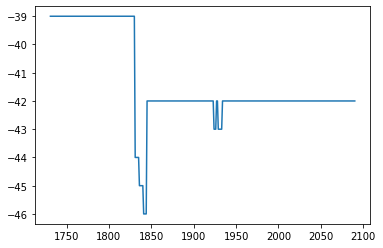

In [459]:
plt.plot(df.RSSI_Left.iloc[1731:1731+360])


In [460]:
df[df.Num_People==0].head()

,Time,Room_Num,Device_ID,RSSI_Left,RSSI_Right,Num_People
6178,3089.0,3,92178,-40,-47,0.0
6179,3089.5,3,92178,-40,-47,0.0
6180,3090.0,3,92178,-40,-47,0.0
6181,3090.5,3,92178,-40,-47,0.0
6182,3091.0,3,92178,-40,-47,0.0


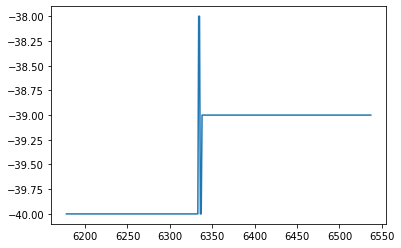

In [461]:
plt.plot(df.RSSI_Left.iloc[6178:6178+360])


In [462]:
df.columns

Index(['Time', 'Room_Num', 'Device_ID', 'RSSI_Left', 'RSSI_Right',
       'Num_People'],
      dtype='object')

In [468]:
people_grouping = (df.groupby('Num_People')['Time'].count()/df.shape[0]).to_dict()

In [10]:
device_minmax = df.groupby('Device_ID')[['RSSI_Left', 'RSSI_Right']].agg({'RSSI_Left':[('RSSI_Left_max','max'), ('RSSI_Left_min','min')],
                                                                          'RSSI_Right':[('RSSI_Right_max','max'), ('RSSI_Right_min','min')]
                                                         }).droplevel(axis=1, level=0)

In [11]:
device_minmax = device_minmax.to_dict(orient='dict')

In [12]:
df.shape[0]/360

7632.616666666667

In [13]:
del df

In [14]:
from sklearn.preprocessing import StandardScaler, normalize, scale

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [617]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, normalize=True):
    # Normalization and Attention
    if normalize:
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    else:
        x = inputs
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=3, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [618]:
def build_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = layers.LayerNormalization(epsilon=1e-6, axis=-1)(inputs)
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, normalize=False)
    for _ in range(num_transformer_blocks-1):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(n_classes, activation="sigmoid")(x)
    outputs = layers.ReLU()(x)
    return keras.Model(inputs, outputs)

In [178]:
x_train.shape

(7549, 2, 3, 360)

In [118]:
def preprocess(df):
    RSSI_Left_diff = df.RSSI_Left.diff().values
    RSSI_Right_diff = df.RSSI_Right.diff().values
    RSSI_Left_diff[0] = RSSI_Right_diff[0] = 0
    
    
    
    RSSI_Left_abs = df.RSSI_Left.abs().values
    RSSI_Right_abs = df.RSSI_Right.abs().values
    left_val = (df['RSSI_Left']-device_minmax['RSSI_Left_min'][df['Device_ID'].iloc[0]])/(device_minmax['RSSI_Left_max'][df['Device_ID'].iloc[0]]-device_minmax['RSSI_Left_min'][df['Device_ID'].iloc[0]])
    right_val = (df['RSSI_Left']-device_minmax['RSSI_Right_min'][df['Device_ID'].iloc[0]])/(device_minmax['RSSI_Right_max'][df['Device_ID'].iloc[0]]-device_minmax['RSSI_Right_min'][df['Device_ID'].iloc[0]])

    
    # x = np.vstack([left_val, RSSI_Left_abs, RSSI_Left_diff, right_val, RSSI_Right_abs, RSSI_Right_diff])
    x1 = np.vstack([left_val, RSSI_Left_abs, RSSI_Left_diff])
    x2 = np.vstack([right_val, RSSI_Right_abs, RSSI_Right_diff])
    x = np.stack([x1,x2])
    y = chunk['Num_People'].iloc[0]
    
    return x, y

In [469]:
test_split = 0.1

0.18303395572705383

In [471]:
chunks = pd.read_csv('data/mafat_wifi_challenge_training_set_v1.csv', chunksize=360)

x_train = []
y_train = []
id_train = []
x_test = []
y_test = []
id_test = []
for idx, chunk in enumerate(chunks):
    
    if chunk['Device_ID'].nunique()!=1:
        # IF a chunk has data from more than one device
        # We put it in the test set after making it into 2 separate chunks of 360
        for device_id, device_chunk in chunk.groupby('Device_ID'):
            x, y = preprocess(device_chunk)
            chunk_id = str(chunk['Device_ID'].iloc[0])+'-'+str(chunk['Room_Num'].iloc[0])+'-'+str(chunk['Time'].iloc[0])
            num_missing = 360-x.shape[-1] # We fill the missing values with the mean
            x = np.concatenate([x, # By adding a matrix of ones (num_missing X 6) multipled by the mean of each feature
                                # (np.ones((num_missing, 6))*[x[0].mean(), 
                                #                             x[1].mean(), 
                                #                             x[2].mean(), 
                                #                             x[3].mean(), 
                                #                             x[4].mean(), 
                                #                             x[5].mean()]).T], 
                                np.repeat(x.mean(axis=-1)[:, :, np.newaxis], num_missing, axis=-1)],
                               axis=-1)
            x_test.append(x)
            y_test.append(y)
            id_test.append(chunk_id)
        continue
    
    x,y = preprocess(chunk)
    chunk_id = str(chunk['Device_ID'].iloc[0])+'-'+str(chunk['Room_Num'].iloc[0])+'-'+str(chunk['Time'].iloc[0])
    
    if np.random.random()<(people_grouping[y]*test_split):
        x_test.append(x)
        y_test.append(y)
        id_test.append(chunk_id)
    else:
        x_train.append(x)
        y_train.append(y)
        id_train.append(chunk_id)
        

In [ ]:
max()

In [472]:
x_train = np.stack(x_train[:-1])
y_train = np.stack(y_train[:-1])


x_test = np.stack(x_test[:-1])
y_test = np.stack(y_test[:-1])


In [473]:
x_train.shape

(7307, 2, 3, 360)

In [474]:
x_test.shape

(407, 2, 3, 360)

(array([2029.,  991., 3205., 1082.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

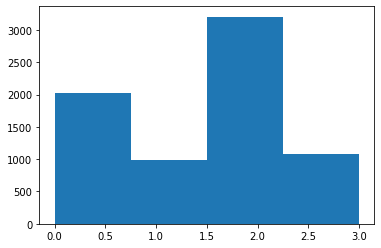

In [475]:
plt.hist(y_train, bins=4)

(array([ 75.,  43., 268.,  21.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

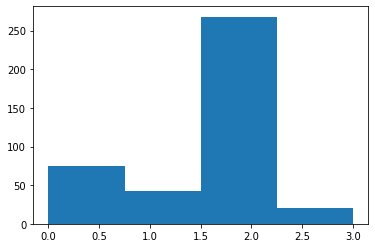

In [476]:
plt.hist(y_test, bins=4)

In [557]:
run_id = 0

In [619]:
# input_shape = x_train.shape[1:]
input_shape = 2,3,360

model = build_model(
    input_shape,
    n_classes=1,
    head_size=12,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=5,
    mlp_units=[128, 32],
    mlp_dropout=0.25,
    dropout=0.33,
)

model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=2e-5, amsgrad=False),
    # optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.75),
    metrics=[keras.metrics.AUC(from_logits=False, name='AUC'), keras.metrics.TruePositives(name='TP'), keras.metrics.FalsePositives(name='FP')],
)

In [624]:
# Define the scheduling function
def schedule(epoch):
    
    def lr(epoch, start_lr=1e-6, min_lr=1e-6, max_lr=1e-5, rampup_epochs = 30, exp_decay = 0.95):
        if epoch < rampup_epochs:
            return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        else:
            return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs) + min_lr
    return lr(epoch)

In [625]:
run_id += 1
history = model.fit(x_train,
                    (y_train>0).astype(int),
                    validation_data=(x_test,(y_test>0).astype(int)),
                    # validation_split=0.2,
                    epochs=200,
                    batch_size=32, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                                             mode='max', 
                                                             patience=10),
                                keras.callbacks.ModelCheckpoint(filepath='models/transformer_run%02d_{epoch:02d}-{val_AUC:.2f}.hdf5'%run_id,
                                                                save_weights_only=True,
                                                                monitor='val_AUC',
                                                                mode='max',
                                                                save_best_only=True),
                               keras.callbacks.LearningRateScheduler(schedule)])

Epoch 1/200
229/229 [==============================] - 11s 49ms/step - loss: 0.6827 - AUC: 0.5115 - TP: 5278.0000 - FP: 2029.0000 - val_loss: 0.6779 - val_AUC: 0.5000 - val_TP: 332.0000 - val_FP: 75.0000 - lr: 1.0000e-06
Epoch 2/200
229/229 [==============================] - 12s 51ms/step - loss: 0.6821 - AUC: 0.5110 - TP: 5278.0000 - FP: 2029.0000 - val_loss: 0.6769 - val_AUC: 0.5000 - val_TP: 332.0000 - val_FP: 75.0000 - lr: 1.3000e-06
Epoch 3/200
229/229 [==============================] - 10s 43ms/step - loss: 0.6815 - AUC: 0.5018 - TP: 5278.0000 - FP: 2029.0000 - val_loss: 0.6758 - val_AUC: 0.5000 - val_TP: 332.0000 - val_FP: 75.0000 - lr: 1.6000e-06
Epoch 4/200
229/229 [==============================] - 12s 52ms/step - loss: 0.6805 - AUC: 0.5091 - TP: 5278.0000 - FP: 2029.0000 - val_loss: 0.6743 - val_AUC: 0.5000 - val_TP: 332.0000 - val_FP: 75.0000 - lr: 1.9000e-06
Epoch 5/200
229/229 [==============================] - 10s 44ms/step - loss: 0.6794 - AUC: 0.5195 - TP: 5278.0000 - 

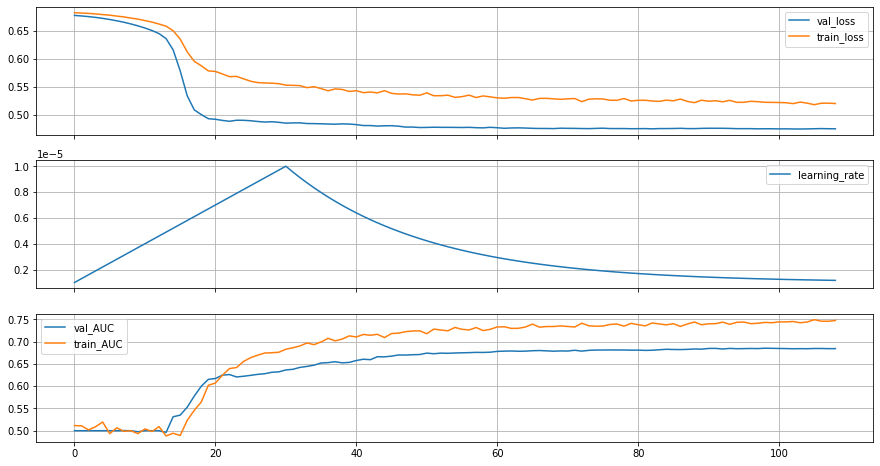

In [626]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.set_size_inches(15,8)
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].plot(history.history['loss'], label='train_loss')
ax[0].legend()
ax[0].grid()
ax[1].plot(history.history['lr'], label='learning_rate')
ax[1].legend()
ax[1].grid()

ax[2].plot(history.history['val_AUC'], label='val_AUC')
ax[2].plot(history.history['AUC'], label='train_AUC')
ax[2].legend()
ax[2].grid()

In [629]:
# Get all checkpoints
checkpoints = glob.glob('models/transformer_run%02d*.hdf5'%run_id)
# Load the latest checkpoint
model.load_weights(checkpoints.pop())
# REmove all other checkpoints
for checkpoint in checkpoints:
    os.remove(checkpoint)

In [630]:
    
model.save('models/transformer_run%02d-%.2f.h5'%(run_id, np.max(history.history['val_AUC'])))

In [631]:
y_pred = model.predict(x_train)

229/229 [==============================] - 4s 14ms/step


In [632]:
max_loss_idxs = np.abs((y_train>0).astype(int)-y_pred[:, 0])>0.4

In [633]:
np.unique(y_train[max_loss_idxs], return_counts=True)

(array([0., 1., 2., 3.]), array([2029,  174,  390,  167]))

In [578]:
np.unique(y_train[max_loss_idxs], return_counts=True)

(array([0., 1., 2., 3.]), array([1539,  196,  446,  163]))

In [579]:
history = model.fit(x_train[max_loss_idxs],
                    (y_train[max_loss_idxs]>0).astype(int),
                    validation_data=(x_test,(y_test>0).astype(int)),
                    # validation_split=0.2,
                    epochs=100,
                    batch_size=256, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3),
                               keras.callbacks.LearningRateScheduler(schedule)])

Epoch 1/100
10/10 [==============================] - 2s 175ms/step - loss: 1.0341 - AUC: 0.2847 - TP: 542.0000 - FP: 1229.0000 - val_loss: 0.4889 - val_AUC: 0.6833 - val_TP: 290.0000 - val_FP: 52.0000 - lr: 1.0000e-07
Epoch 2/100
10/10 [==============================] - 2s 169ms/step - loss: 1.0299 - AUC: 0.2829 - TP: 527.0000 - FP: 1221.0000 - val_loss: 0.4892 - val_AUC: 0.6837 - val_TP: 289.0000 - val_FP: 52.0000 - lr: 4.3000e-07
Epoch 3/100
10/10 [==============================] - 2s 168ms/step - loss: 1.0327 - AUC: 0.2848 - TP: 533.0000 - FP: 1224.0000 - val_loss: 0.4901 - val_AUC: 0.6831 - val_TP: 288.0000 - val_FP: 52.0000 - lr: 7.6000e-07
Epoch 4/100
10/10 [==============================] - 2s 166ms/step - loss: 1.0153 - AUC: 0.2839 - TP: 513.0000 - FP: 1218.0000 - val_loss: 0.4912 - val_AUC: 0.6837 - val_TP: 287.0000 - val_FP: 50.0000 - lr: 1.0900e-06


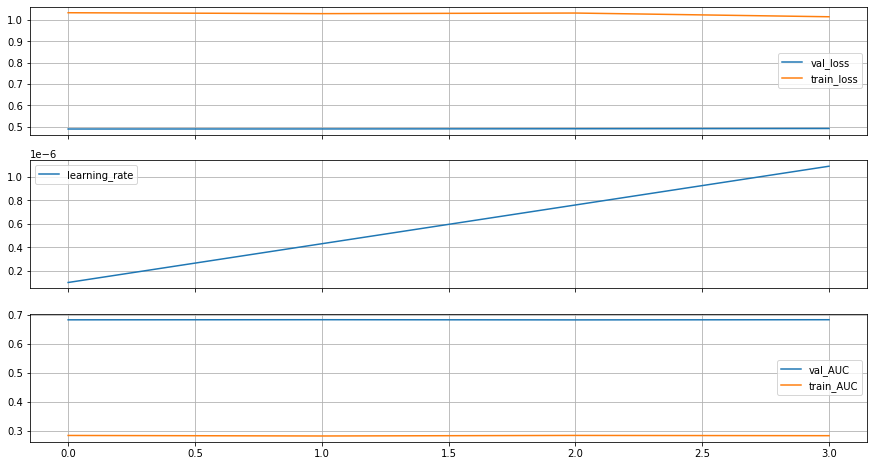

In [580]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.set_size_inches(15,8)
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].plot(history.history['loss'], label='train_loss')
ax[0].legend()
ax[0].grid()
ax[1].plot(history.history['lr'], label='learning_rate')
ax[1].legend()
ax[1].grid()

ax[2].plot(history.history['val_AUC'], label='val_AUC')
ax[2].plot(history.history['AUC'], label='train_AUC')
ax[2].legend()
ax[2].grid()

In [607]:
y_pred = model.predict(x_test)

max_loss_idx = np.abs((y_test>0).astype(int)-y_pred[:, 0]).argmax()

13/13 [==============================] - 0s 15ms/step


In [608]:
y_test[max_loss_idx]

0.0

In [609]:
y_pred[max_loss_idx]

array([0.8811646], dtype=float32)

In [610]:
max_loss_idxs = np.abs((y_test>0).astype(int)-y_pred[:, 0])>0.5

In [611]:
y_test[max_loss_idxs]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [612]:
y_pred[max_loss_idxs].flatten()

array([0.6506898 , 0.6506898 , 0.6506898 , 0.6801762 , 0.7581751 ,
       0.7852679 , 0.76975876, 0.667519  , 0.80948544, 0.6484757 ,
       0.6506879 , 0.62732357, 0.7977558 , 0.6333861 , 0.6583125 ,
       0.6506868 , 0.80027306, 0.58624905, 0.6128377 , 0.68339556,
       0.6396822 , 0.68223655, 0.66512936, 0.61980695, 0.6359303 ,
       0.63855726, 0.6970244 , 0.64759713, 0.5883759 , 0.7433568 ,
       0.5843501 , 0.64365643, 0.6326619 , 0.59894717, 0.6343868 ,
       0.69404554, 0.58961236, 0.6016772 , 0.81705403, 0.61820203,
       0.62544364, 0.6482033 , 0.69443774, 0.69600815, 0.77463716,
       0.7633208 , 0.643358  , 0.65068614, 0.6506873 , 0.8360554 ,
       0.6171062 , 0.69657195, 0.6506729 , 0.79975325, 0.6506874 ,
       0.6365468 , 0.6135523 , 0.7018242 , 0.76362234, 0.64950436,
       0.6199743 , 0.75025165, 0.6039822 , 0.62463325, 0.8676855 ,
       0.6840599 , 0.6345112 , 0.80066675, 0.8811646 , 0.7611854 ,
       0.8627115 , 0.77784866, 0.64307004, 0.65068495, 0.66860

In [613]:
x_test[max_loss_idxs].shape

(75, 2, 3, 360)

In [614]:
x_test[max_loss_idxs&(y_test!=0), row, col].shape

(0, 360)

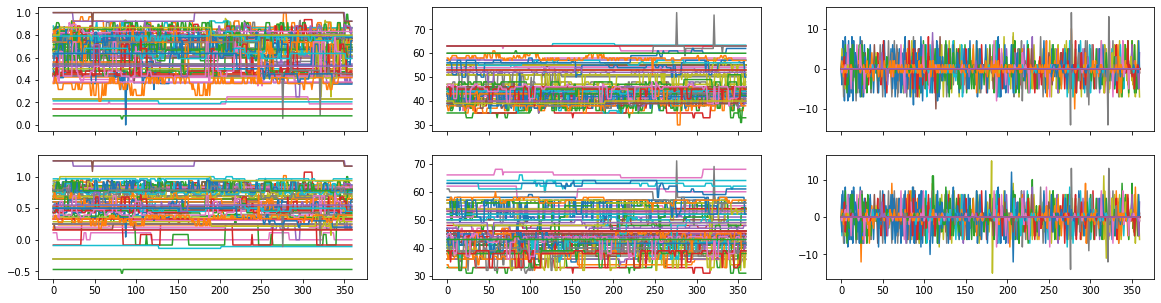

In [616]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)
fig.set_size_inches(20, 5)
for row in range(2):
    for col in range(3):
        ax[row, col].plot(x_test[max_loss_idxs&(y_test==0) , row, col].T)
        # ax[row, col].plot(x_test[max_loss_idxs & (y_test!=0), row, col], color='blue')

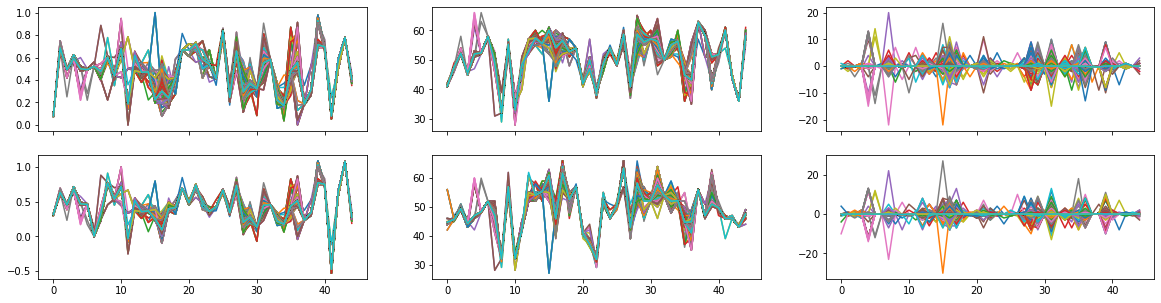

In [592]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)
fig.set_size_inches(20, 5)
for row in range(2):
    for col in range(3):
        ax[row, col].plot(x_test[max_loss_idxs&(y_test!=0) , row, col])
        # ax[row, col].plot(x_test[max_loss_idxs & (y_test!=0), row, col], color='blue')

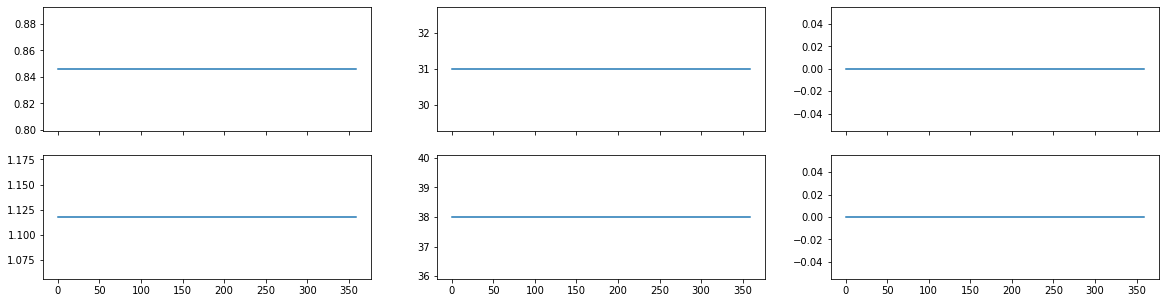

In [216]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)
fig.set_size_inches(20, 5)
for row in range(2):
    for col in range(3):
        ax[row, col].plot(x_train[max_loss_idx, row, col])

In [296]:
history = model.fit(x_train,
                    (y_train>0).astype(int),
                    validation_data=(x_test,(y_test>0).astype(int)),
                    epochs=100,
                    batch_size=512, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)])

Epoch 1/100
15/15 [==============================] - 4s 230ms/step - loss: 0.4797 - AUC: 0.7878 - TP: 4951.0000 - FP: 1165.0000 - val_loss: 0.6023 - val_AUC: 0.5535 - val_TP: 85.0000 - val_FP: 8.0000
Epoch 2/100
15/15 [==============================] - 4s 234ms/step - loss: 0.4731 - AUC: 0.7939 - TP: 5064.0000 - FP: 1158.0000 - val_loss: 0.5775 - val_AUC: 0.5558 - val_TP: 109.0000 - val_FP: 9.0000
Epoch 3/100
15/15 [==============================] - 4s 256ms/step - loss: 0.4658 - AUC: 0.8040 - TP: 5075.0000 - FP: 1141.0000 - val_loss: 0.5960 - val_AUC: 0.5598 - val_TP: 86.0000 - val_FP: 8.0000
Epoch 4/100
15/15 [==============================] - 4s 244ms/step - loss: 0.4605 - AUC: 0.8073 - TP: 5080.0000 - FP: 1115.0000 - val_loss: 0.5618 - val_AUC: 0.5632 - val_TP: 109.0000 - val_FP: 9.0000
Epoch 5/100
15/15 [==============================] - 3s 231ms/step - loss: 0.4579 - AUC: 0.8102 - TP: 5051.0000 - FP: 1086.0000 - val_loss: 0.6107 - val_AUC: 0.5733 - val_TP: 86.0000 - val_FP: 8.000

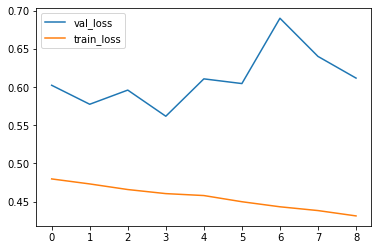

In [297]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

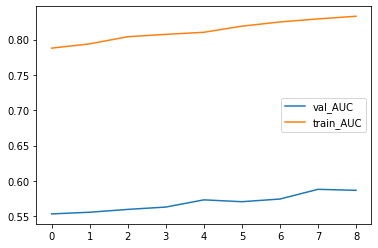

In [298]:
plt.plot(history.history['val_AUC'], label='val_AUC')
plt.plot(history.history['AUC'], label='train_AUC')
plt.legend()

In [384]:
y_pred = model.predict(x_test)

6/6 [==============================] - 1s 15ms/step


In [385]:
max_loss_idx = np.abs((y_test>0).astype(int)-y_pred[:, 0]).argmax()

In [386]:
max_loss_idxs = np.abs((y_test>0).astype(int)-y_pred[:, 0])>0.5

In [387]:
y_test[max_loss_idxs]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [388]:
y_pred[max_loss_idxs].flatten()

array([0.5268404 , 0.6602993 , 0.5763405 , 0.58617014, 0.74631107,
       0.5669933 , 0.6833314 , 0.55122507, 0.558678  , 0.7589646 ,
       0.577458  , 0.53911465, 0.8256966 , 0.558019  ], dtype=float32)

In [389]:
x_test[max_loss_idxs].shape

(14, 2, 3, 360)

In [390]:
x_test[max_loss_idxs&(y_test!=0), row, col].shape

(0, 360)

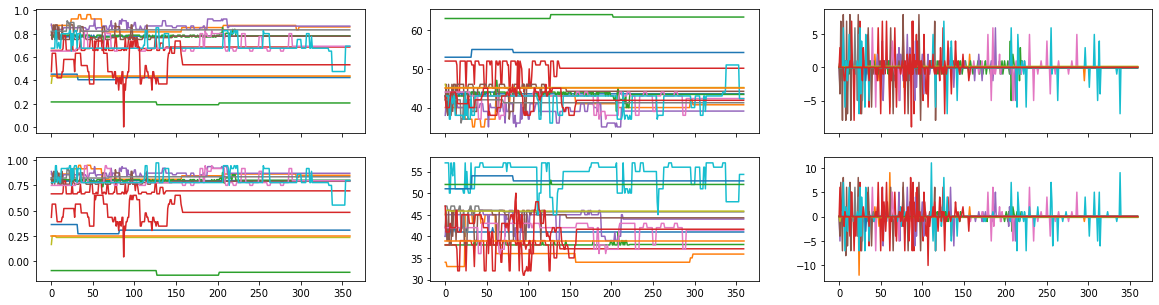

In [391]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)
fig.set_size_inches(20, 5)
for row in range(2):
    for col in range(3):
        ax[row, col].plot(x_test[max_loss_idxs&(y_test==0) , row, col].T)
        # ax[row, col].plot(x_test[max_loss_idxs & (y_test!=0), row, col], color='blue')

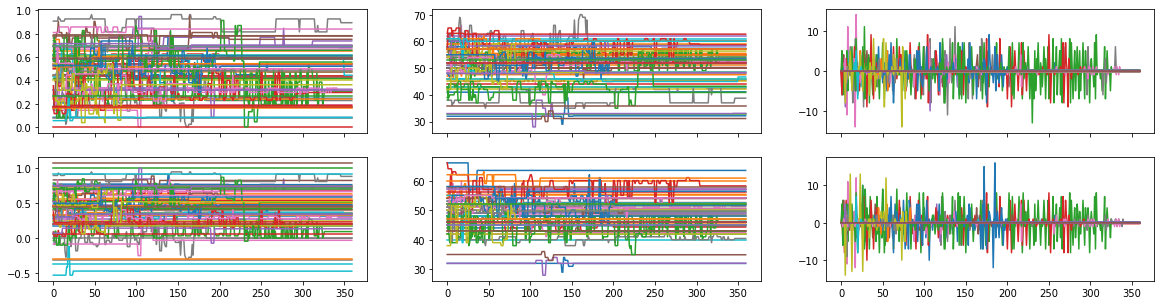

In [307]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True)
fig.set_size_inches(20, 5)
for row in range(2):
    for col in range(3):
        ax[row, col].plot(x_test[max_loss_idxs&(y_test!=0) , row, col].T)
        # ax[row, col].plot(x_test[max_loss_idxs & (y_test!=0), row, col], color='blue')

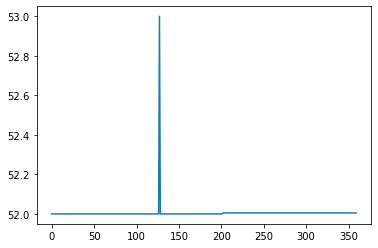

In [102]:
plt.plot(x_test[max_loss_idx, 4])

In [265]:
history = model.fit(x_train,
          (y_train>0).astype(int),
          validation_split=0.2,
          epochs=100,
          batch_size=2048, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)])

Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 0.5720 - auc_26: 0.6780 - true_positives_10: 4192.0000 - false_positives_9: 1760.0000 - val_loss: 0.4891 - val_auc_26: 0.6275 - val_true_positives_10: 1221.0000 - val_false_positives_9: 288.0000
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.5742 - auc_26: 0.6751 - true_positives_10: 4192.0000 - false_positives_9: 1764.0000 - val_loss: 0.4891 - val_auc_26: 0.6277 - val_true_positives_10: 1221.0000 - val_false_positives_9: 288.0000
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.5749 - auc_26: 0.6728 - true_positives_10: 4202.0000 - false_positives_9: 1768.0000 - val_loss: 0.4890 - val_auc_26: 0.6278 - val_true_positives_10: 1221.0000 - val_false_positives_9: 288.0000
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.5745 - auc_26: 0.6738 - true_positives_10: 4183.0000 - false_positives_9: 1766.0000 - val_loss: 0.4889 - val_auc_26: 0.6281 - val_tru

In [13]:
x_train.shape

(100, 2, 360)

In [14]:
y_train.shape

(100,)

In [15]:
x.shape

(2, 360)

In [28]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 360)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 2, 360)      720         ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 2, 360)      1477992     ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                              

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

2/2 [==============================] - 3s 371ms/step - loss: 0.6929 - sparse_categorical_accuracy: 0.3000 - val_loss: 0.6895 - val_sparse_categorical_accuracy: 0.0500
